In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import Resize
from torch.cuda.amp import GradScaler, autocast
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

from monai import transforms
from monai.data import CacheDataset, DataLoader
from monai.utils import set_determinism

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

In [2]:
# data_dir = '/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/MICCAI/complete_mednode_dataset'
data_dir = r"D:\alzor\Documents\Dropbox\MICCAI\complete_mednode_dataset"
melanoma_dir = data_dir + '/melanoma'
# naevus_dir = data_dir + '/naevus'

In [3]:
set_determinism(seed = 0)

In [4]:
# Obtenemos los nombres de los ficheros en los directorios de melanoma y naevus
melanoma_files = [os.path.join(melanoma_dir, x) for x in os.listdir(melanoma_dir)]
# naevus_files = [os.path.join(naevus_dir, x) for x in os.listdir(naevus_dir)]

In [5]:
melanoma_files[0]

'D:\\alzor\\Documents\\Dropbox\\MICCAI\\complete_mednode_dataset/melanoma\\136733.jpg'

In [6]:
# Cargamos las imágenes jpg de melanoma y naevus en un tensor de Pytorch
melanoma_images = []
# naevus_images = []
for image in melanoma_files:
    melanoma_images.append(plt.imread(image))
# for image in naevus_files:
#     naevus_images.append(plt.imread(image))

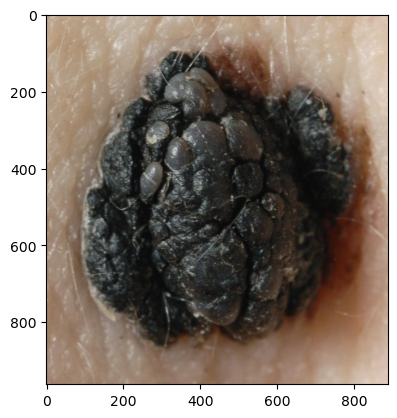

In [7]:
plt.imshow(melanoma_images[0])

In [8]:
type(melanoma_images[0])

numpy.ndarray

In [9]:
# Transformamos las imágenes a tensores de Pytorch
melanoma_tensors = []
# naevus_tensors = []
for image in melanoma_images:
    melanoma_tensors.append(torch.tensor(image))
# for image in naevus_images:
#     naevus_tensors.append(torch.tensor(image))

In [10]:
melanoma_tensors[0].shape

torch.Size([962, 888, 3])

In [11]:
# Intercambiamos los ejes de las imágenes para que tengan el formato correcto
melanoma_tensors = [torch.transpose(image, 0, 2) for image in melanoma_tensors]
# naevus_tensors = [torch.transpose(image, 0, 2) for image in naevus_tensors]

In [12]:
melanoma_tensors[0].shape

torch.Size([3, 888, 962])

In [13]:
# Redimensionamos las imágenes a otro tamaño
resize = Resize((128, 128))
melanoma_tensors_resized = []
# naevus_tensors_resized = []
for image in melanoma_tensors:
    melanoma_tensors_resized.append(resize(image))
# for image in naevus_tensors:
#     naevus_tensors_resized.append(resize(image))

In [14]:
melanoma_tensors_resized[0].shape

torch.Size([3, 128, 128])

In [15]:
len(melanoma_tensors_resized)

70

In [16]:
# Convertimos las listas de imágenes en tensores de Pytorch
melanoma_Tensor = torch.stack(melanoma_tensors_resized)
# naevus_Tensor = torch.stack(naevus_tensors_resized)

# Normalizamos los tensores al rango [0,1]
melanoma_Tensor = melanoma_Tensor / 255
# naevus_Tensor = naevus_Tensor / 255

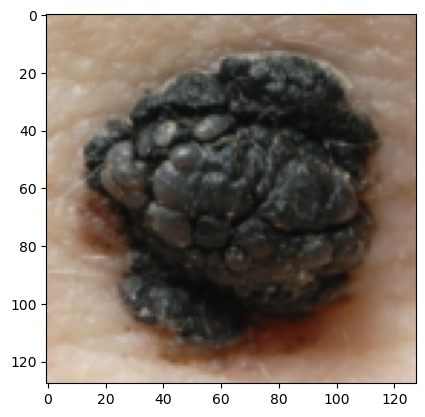

In [17]:
# Mostrar una imagen de melanoma
plt.imshow(melanoma_Tensor[0].permute(1, 2, 0))

In [18]:
# Creamos un dataset de entrenamiento y de validación con las imágenes de melanoma y naevus
# train_dataset = CacheDataset(data = torch.cat((melanoma_Tensor[0:49],naevus_Tensor[0:70])), transform = transforms.ToTensor())
# val_dataset = CacheDataset(data = torch.cat((melanoma_Tensor[49:],naevus_Tensor[70:])), transform = transforms.ToTensor())


train_dataset = CacheDataset(data = melanoma_Tensor[0:59], transform = transforms.ToTensor())
val_dataset = CacheDataset(data = melanoma_Tensor[59:], transform = transforms.ToTensor())

Loading dataset: 100%|██████████| 11/11 [00:00<?, ?it/s]


In [19]:
# Creamos un DataLoader de Pytorch con el dataset
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = True)

In [20]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(256, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

d:\programas\anaconda\envs\tfm\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 1000/1000 [07:25<00:00,  2.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


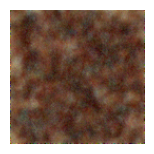

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


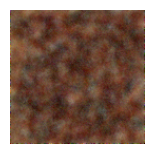

100%|██████████| 1000/1000 [07:29<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


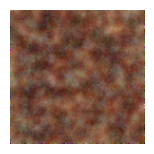

100%|██████████| 1000/1000 [07:27<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


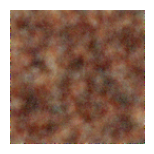

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


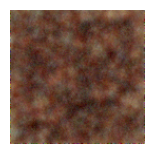

100%|██████████| 1000/1000 [07:29<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


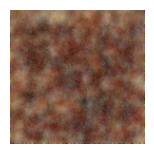

100%|██████████| 1000/1000 [07:29<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


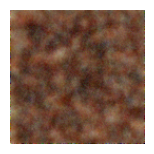

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


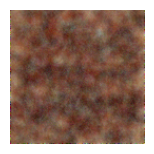

Entrenamiento completado, total time: 17584.888885498047.


In [21]:
n_epochs = 200 # Número de épocas
val_interval = 25 # Intervalo de épocas para calcular la pérdida respecto al conjunto de validación
epoch_loss_list = [] # Para almacenar los valores de la función de pérdida en cada época
val_epoch_loss_list = []

lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
lr_value_list = []

scaler = GradScaler()
total_start = time.time()

# Entrenamiento del modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer) # Actualizamos los pesos del modelo
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    lr_value_list.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss_list[-1])

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Generamos una imagen durante el entrenamiento para observar la mejora de la calidad de las imágenes generadas
        # y calcular distintas métricas de calidad de las imágenes generadas (FID, SSIM, PSNR, etc.) y observar su evolución.
        n_synthetic_images = 1
        noise = torch.randn((n_synthetic_images, 3, 128, 128))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
        # Ploteamos una de las imágenes generadas
        plt.figure(figsize=(2, 2))
        plt.imshow(syn_images[0].cpu().permute(1, 2, 0))
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        """
        # Calculamos el FID entre las imágenes generadas y la distrbución de las imágenes de validación
        synth_features = []
        synth_eval_feats = get_features(syn_images)
        synth_features.append(synth_eval_feats)
        synth_features = torch.vstack(synth_features)
        fid_res = fid(synth_features, real_features)
        fid_epoch_list.append(fid_res.item())
        """

total_time = time.time() - total_start
print(f"Entrenamiento completado, total time: {total_time}.")

In [22]:
torch.save(model.state_dict(), r"D:\DDPM_models\ddpm2d_skin_model.pt")

In [23]:
# Guardamos en un fichero csv los valores de la función de pérdida y del FID para cada epoch.
import csv

with open(r"D:\DDPM_models\ddpm2d_skin_model_numeric_results.csv", mode="w") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Learning Rate"])
    i = 0
    for epoch in range(n_epochs):
        if (epoch+1) % val_interval == 0:
            writer.writerow([epoch + 1, epoch_loss_list[epoch], val_epoch_loss_list[i], lr_value_list[epoch]])
            i += 1
        else:
            writer.writerow([epoch + 1, epoch_loss_list[epoch], "", lr_value_list[epoch]])